In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import time

import sys
sys.path.append('..')
from src.utils.plotting import plot_roc

from joblib import dump, load
import pickle
import os
import shutil
from tqdm import tqdm

import featuretools as ft
from featuretools import selection

import xgboost as xgb
import lightgbm as lgbm

from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor

pd.options.mode.use_inf_as_na = True

data_folder = '/media/siri/78C6823EC681FD1E/minio/data/kaggle/ncaa/'

### Read Feature Matrices and combine into one

In [2]:
total_chunks = 300

In [3]:
fm_lst = []
#for i in range(1, 6):
for i in tqdm(range(0, total_chunks)):
    fmi = pd.read_parquet(data_folder+'p{}_fm'.format(i))
    fm_lst.append(fmi)
fm = pd.concat(fm_lst, axis=0, copy=False)
#fm = selection.remove_low_information_features(fm)
#del fm_lst
fm.info()

100%|██████████| 300/300 [00:25<00:00, 11.83it/s]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 319500 entries, 0 to 319499
Columns: 534 entries, time to WTeams.TIME_SINCE_LAST(WTeam_events.Date)
dtypes: datetime64[ns](1), float64(529), int64(2), object(2)
memory usage: 1.3+ GB


In [4]:
fm = selection.remove_low_information_features(fm)
fm.head()

,time,CityID,GameID,LAst,LBlk,LDR,LFGA,LFGA3,LFGM,LFGM3,...,WTeams.STD(WTeam_events.LPoints),WTeams.STD(WTeam_events.ElapsedSeconds),WTeams.SKEW(WTeam_events.WPoints),WTeams.SKEW(WTeam_events.LPoints),WTeams.SKEW(WTeam_events.ElapsedSeconds),WTeams.MEDIAN(WTeam_events.WPoints),WTeams.MEDIAN(WTeam_events.LPoints),WTeams.MEDIAN(WTeam_events.ElapsedSeconds),WTeams.AVG_TIME_BETWEEN(WTeam_events.Date),WTeams.TIME_SINCE_LAST(WTeam_events.Date)
Game_WTeamID,,,,,,,,,,,,,,,,,,,,,
0,1984-10-28 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1984-10-28 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1984-10-28 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1984-10-28 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1984-10-28 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
fm.columns

Index(['time', 'CityID', 'GameID', 'LAst', 'LBlk', 'LDR', 'LFGA', 'LFGA3',
       'LFGM', 'LFGM3',
       ...
       'WTeams.STD(WTeam_events.LPoints)',
       'WTeams.STD(WTeam_events.ElapsedSeconds)',
       'WTeams.SKEW(WTeam_events.WPoints)',
       'WTeams.SKEW(WTeam_events.LPoints)',
       'WTeams.SKEW(WTeam_events.ElapsedSeconds)',
       'WTeams.MEDIAN(WTeam_events.WPoints)',
       'WTeams.MEDIAN(WTeam_events.LPoints)',
       'WTeams.MEDIAN(WTeam_events.ElapsedSeconds)',
       'WTeams.AVG_TIME_BETWEEN(WTeam_events.Date)',
       'WTeams.TIME_SINCE_LAST(WTeam_events.Date)'],
      dtype='object', length=533)

In [6]:
fm = fm.drop(columns=['GameID', 'CityID','WTeamID', 'LTeamID','time'])
fm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319500 entries, 0 to 319499
Columns: 528 entries, LAst to WTeams.TIME_SINCE_LAST(WTeam_events.Date)
dtypes: float64(524), int64(2), object(2)
memory usage: 1.3+ GB


In [7]:
fm.index.is_unique

True

#### Convert TourneyName to categorical and add outcome column

In [8]:
def convert_to_categorical(series):
    values = series.unique()
    cat_map = {cat_val:cat_num  for cat_num, cat_val in enumerate(values)}    
    return series.map(cat_map), cat_map 

In [9]:
#fm['Outcome'] = 0
#fm = fm.apply(set_game_outcome, axis=1)
fm['TourneyName'], tourney_cat_map = convert_to_categorical(fm['TourneyName'])

fm['WLoc'], wloc_cat_map = convert_to_categorical(fm['WLoc'])

In [10]:
outcomes = pd.read_parquet(data_folder+'labels')
fm = fm.merge(outcomes, how='left', left_index=True, right_index=True)
test_cond = (fm.Season > 2013) & (fm.TourneyName == tourney_cat_map['NCAA'])
#fm = fm.drop(columns=['Season','WTeamID','LTeamID'])
fm.head()

,LAst,LBlk,LDR,LFGA,LFGA3,LFGM,LFGM3,LFTA,LFTM,LOR,...,WTeams.STD(WTeam_events.ElapsedSeconds),WTeams.SKEW(WTeam_events.WPoints),WTeams.SKEW(WTeam_events.LPoints),WTeams.SKEW(WTeam_events.ElapsedSeconds),WTeams.MEDIAN(WTeam_events.WPoints),WTeams.MEDIAN(WTeam_events.LPoints),WTeams.MEDIAN(WTeam_events.ElapsedSeconds),WTeams.AVG_TIME_BETWEEN(WTeam_events.Date),WTeams.TIME_SINCE_LAST(WTeam_events.Date),Outcome
Game_WTeamID,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [11]:
X_test = fm.loc[test_cond]
X_train = fm.loc[~test_cond]
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 603 entries, 137590 to 314108
Columns: 529 entries, LAst to Outcome
dtypes: float64(524), int64(5)
memory usage: 2.4 MB


In [12]:
y_train = X_train['Outcome']
y_test = X_test['Outcome']
X_train = X_train.drop(columns=['Outcome'])
X_test = X_test.drop(columns=['Outcome'])
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318897 entries, 0 to 319499
Columns: 528 entries, LAst to WTeams.TIME_SINCE_LAST(WTeam_events.Date)
dtypes: float64(524), int64(4)
memory usage: 1.3 GB


In [13]:
del fm, fm_lst

In [14]:
target_names = ['wins', 'losses']

### Feature Selection

In [30]:
#cv_lgbm = load(data_folder+'cv_lgbm.joblib')

clf_lgbm_model = lgbm.LGBMClassifier(random_state=40,
                                  objective='binary',
                                  #n_estimators=cv_lgbm.best_params_['n_estimators'],
                                  #min_split_gain=cv_lgbm.best_params_['min_split_gain'],
                                  #learning_rate=cv_lgbm.best_params_['learning_rate'],
                                  #reg_lambda=cv_lgbm.best_params_['reg_lambda'],
                                  #max_depth=cv_lgbm.best_params_['max_depth'],
                                  n_jobs=3)
start = time.time()
clf_lgbm_model.fit(X_train, y_train)
end = time.time()
print(end - start)

92.86999416351318


In [31]:
y_pred_lgbm = clf_lgbm_model.predict_proba(X_test)

def prob_to_bin(probs, threshold=0.5):
    probs = probs[:,1]
    bin_vals = pd.Series(np.zeros_like(probs))
    bin_vals.loc[probs > threshold] = 1
    return bin_vals
y_pred_bins = prob_to_bin(y_pred_lgbm)

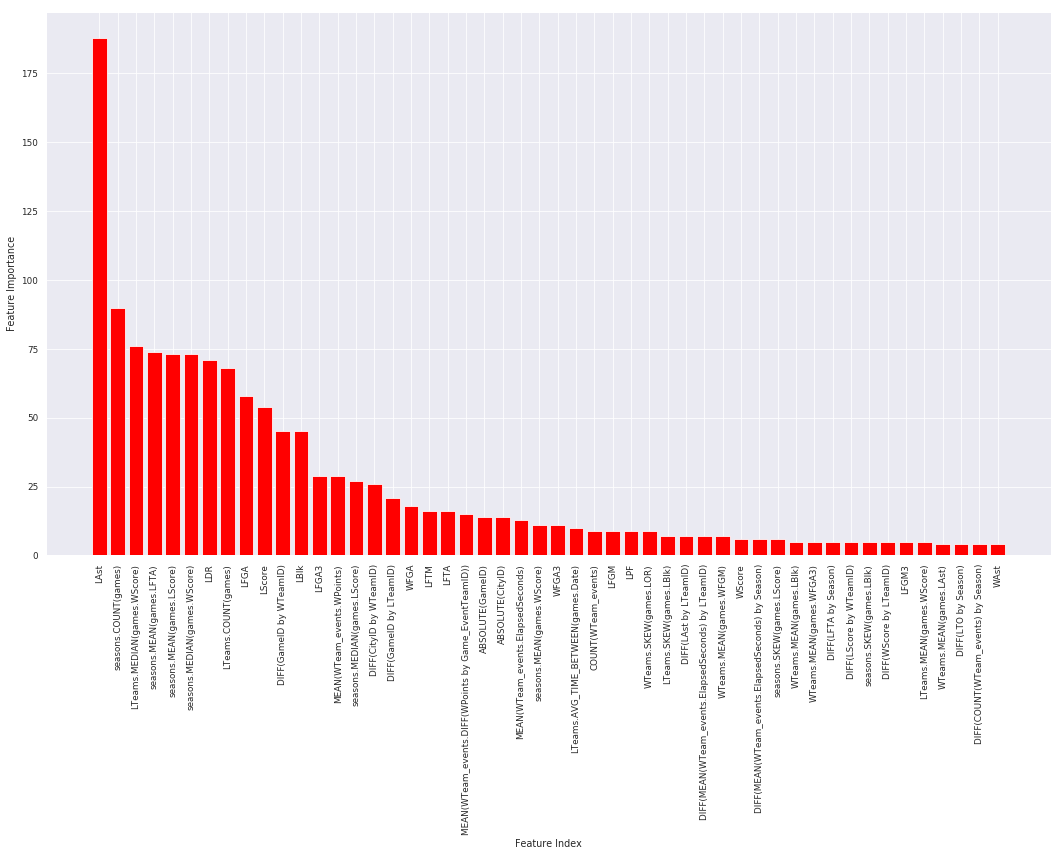

In [32]:
importances = clf_lgbm_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(18,10))
# names of important features based on plot above
important_features_idx = [idx for idx in sorted_idx if importances[idx] > 0.0]
important_features = {idx:X_train.columns[idx] for idx in important_features_idx}
# plot top 50 features
plt.bar(range(50), importances[list(important_features.keys())[:50]], color='r', align='center')
plt.xticks(range(50), list(important_features.values())[:50], rotation='vertical')
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.show()

### Drop unimportant Features

In [35]:
X_train = X_train[X_train.columns[important_features_idx]]
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 318897 entries, 0_1116 to 9_1333
Columns: 278 entries, LAst to LTeams.MEAN(games.WFTA)
dtypes: float64(271), int64(7)
memory usage: 678.8+ MB


In [36]:
X_test = X_test[X_test.columns[important_features_idx]]
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 603 entries, 1849_1107 to 2183_1437
Columns: 278 entries, LAst to LTeams.MEAN(games.WFTA)
dtypes: float64(271), int64(7)
memory usage: 1.3+ MB


### Modeling

In [15]:
# Model selection
params_lgbm = {'n_estimators' : [1, 2, 4, 8, 16, 32, 64, 100, 200],
               'learning_rate' : np.linspace(.1, 1, 5, endpoint=True),
               'min_split_gain' : np.linspace(0.1, 1.0, 10, endpoint=True),
               'reg_lambda': np.linspace(0.1, 10, 10, endpoint=True),
               'max_depth' : np.linspace(8, 32, 10, dtype=int),
               'num_leaves': np.linspace(20, 200, 10, dtype=int)
                 }
start = time.time()
cv_lgbm = RandomizedSearchCV(lgbm.LGBMClassifier(objective='binary',random_state=42), param_distributions=params_lgbm, cv=5, n_jobs=3, random_state=42)
cv_lgbm.fit(X_train, y_train)
end = time.time()
print(end - start)

dump(cv_lgbm, data_folder+'cv_lgbm.joblib')

601.5412118434906


['/media/siri/78C6823EC681FD1E/minio/data/kaggle/ncaa/cv_lgbm.joblib']

In [16]:
#cv_lgbm = load(data_folder+'cv_lgbm.joblib')

clf_lgbm_model = lgbm.LGBMClassifier(random_state=40,
                                  objective='binary',
                                  n_estimators=cv_lgbm.best_params_['n_estimators'],
                                  min_split_gain=cv_lgbm.best_params_['min_split_gain'],
                                  learning_rate=cv_lgbm.best_params_['learning_rate'],
                                  reg_lambda=cv_lgbm.best_params_['reg_lambda'],
                                  max_depth=cv_lgbm.best_params_['max_depth'],
                                  num_leaves=cv_lgbm.best_params_['num_leaves'],
                                  n_jobs=3)
start = time.time()
clf_lgbm_model.fit(X_train, y_train)
end = time.time()
print(end - start)

9.968096733093262


In [17]:
y_pred_lgbm = clf_lgbm_model.predict_proba(X_test)

def prob_to_bin(probs, threshold=0.5):
    probs = probs[:,1]
    bin_vals = pd.Series(np.zeros_like(probs))
    bin_vals.loc[probs > threshold] = 1
    return bin_vals
y_pred_bins = prob_to_bin(y_pred_lgbm)

In [18]:
score_lgbm = accuracy_score(y_test, y_pred_bins)
rscore_lgbm = recall_score(y_test, y_pred_bins)
pscore_lgbm = precision_score(y_test, y_pred_bins)
print('Accuracy score for LightGBM ', score_lgbm)
print('Recall score for LightGBM ', rscore_lgbm)
print('Precision score for LightGBM ', pscore_lgbm)
print(classification_report(y_test, y_pred_bins, target_names=target_names))

Accuracy score for LightGBM  0.9983416252072969
Recall score for LightGBM  0.9970149253731343
Precision score for LightGBM  1.0
              precision    recall  f1-score   support

        wins       1.00      1.00      1.00       268
      losses       1.00      1.00      1.00       335

   micro avg       1.00      1.00      1.00       603
   macro avg       1.00      1.00      1.00       603
weighted avg       1.00      1.00      1.00       603



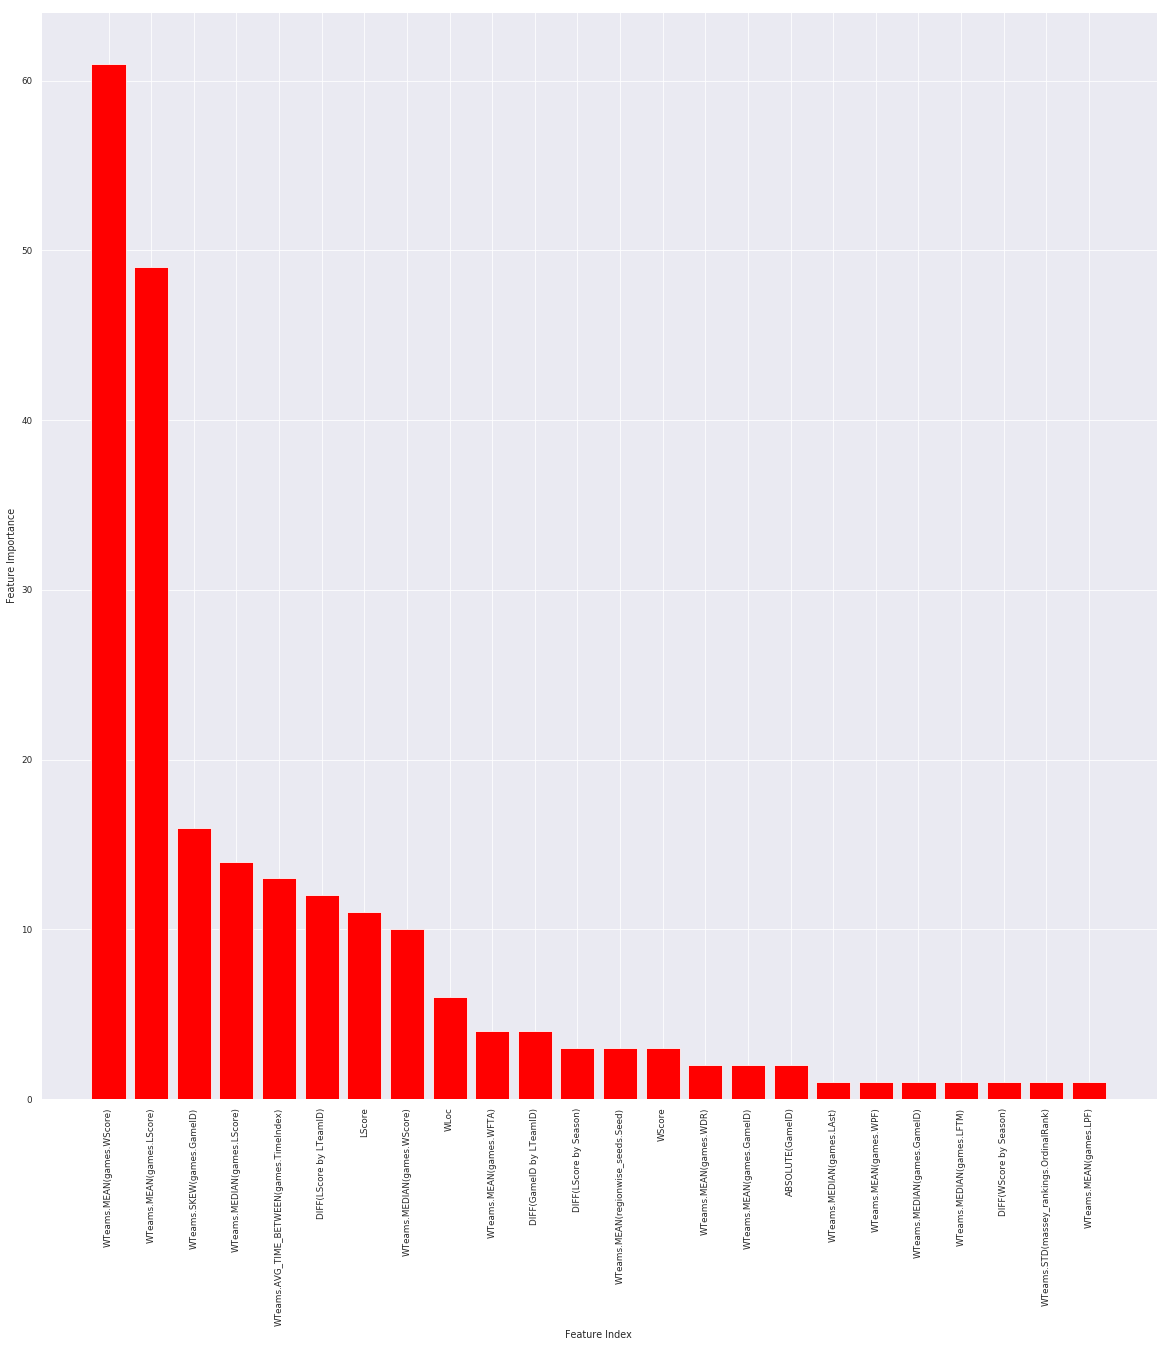

In [19]:
importances = clf_lgbm_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(20,20))
# names of important features based on plot above
important_features_idx = [idx for idx in sorted_idx if importances[idx] > 0.0]
important_features = {idx:X_train.columns[idx] for idx in important_features_idx}

# plot top 50 features
plt.bar(range(len(important_features_idx)), importances[list(important_features.keys())], color='r', align='center')
plt.xticks(range(len(important_features_idx)), list(important_features.values()), rotation='vertical')
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.show()

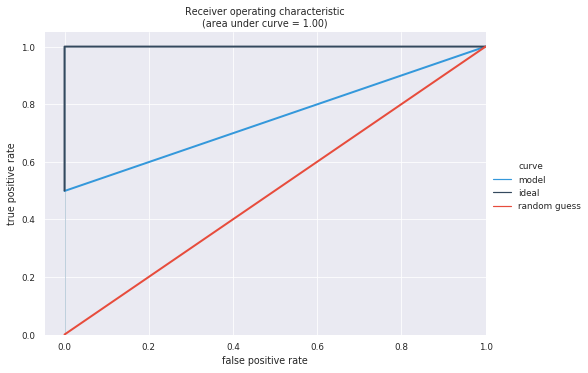

In [20]:
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test, y_pred_bins)
lgbm_roc_auc = auc(lgbm_fpr, lgbm_tpr)

plot_roc(lgbm_fpr, lgbm_tpr, lgbm_roc_auc)

### predicting for 2019

In [48]:
X_train.columns[X_train.columns.duplicated()]

Index(['seasons.COUNT(games)', 'LTeams.MEDIAN(games.WScore)',
       'seasons.MEAN(games.LFTA)', 'seasons.MEAN(games.LScore)',
       'seasons.MEDIAN(games.WScore)', 'LTeams.COUNT(games)',
       'DIFF(GameID by WTeamID)', 'DIFF(GameID by WTeamID)',
       'MEAN(WTeam_events.WPoints)', 'seasons.MEDIAN(games.LScore)',
       ...
       'LTeams.MEAN(games.LFTA)', 'DIFF(WFGM3 by WTeamID)',
       'DIFF(WFGM3 by WTeamID)', 'LTeams.STD(games.LFGA)',
       'DIFF(WOR by Season)', 'DIFF(WOR by Season)',
       'STD(WTeam_events.ElapsedSeconds)', 'LTeams.MEAN(games.WFGA)',
       'seasons.MEAN(games.LDR)', 'LTeams.MEAN(games.WFTA)'],
      dtype='object', length=136)

In [21]:
params_xgb = {'n_estimators' : [1,2,4,8,16,32,64,128,256],
          'gamma' : np.linspace(0.01,1,10, endpoint=True),
          'learning_rate' : np.linspace(.01, 1, 10, endpoint=True),
          'reg_lambda' : np.linspace(.01, 10, 10, endpoint=True),
          'max_depth' : np.linspace(1, 32, 10, endpoint=True, dtype=int)
        }
start = time.time()
cv_xgb  = RandomizedSearchCV(xgb.XGBClassifier(objective='binary:logistic',random_state=42), param_distributions=params_xgb, 
                             random_state=42, cv=5, n_jobs=4)
cv_xgb.fit(X_train, y_train)
end = time.time()
print(end - start)

KeyboardInterrupt: 

In [ ]:
dump(cv_xgb, data_folder+'xgb_ramdomcv.joblib')

In [ ]:
cv_xgb = load(data_folder+'logr_ramdomcv.joblib')

In [18]:
clf_xgb_model = xgb.XGBClassifier(random_state=42,
                                  objective='binary:logistic',
                                  n_estimators=cv_xgb.best_params_['n_estimators'],
                                  gamma=cv_xgb.best_params_['gamma'],
                                  learning_rate=cv_xgb.best_params_['learning_rate'],
                                  reg_lambda=cv_xgb.best_params_['reg_lambda'],
                                  max_depth=cv_xgb.best_params_['max_depth'],
                                  n_jobs=3)
start = time.time()
clf_xgb_model.fit(X_train, y_train)
end = time.time()
print(end - start)

49.711326122283936


In [21]:
y_pred_xgb = clf_xgb_model.predict(X_test)
score_xgb = accuracy_score(y_test, y_pred_xgb)
rscore_xgb = recall_score(y_test, y_pred_xgb)
pscore_xgb = precision_score(y_test, y_pred_xgb)
print('Accuracy score for XGBoost ', score_xgb)
print('Recall score for XGBoost ', rscore_xgb)
print('Precision score for XGBoost ', pscore_xgb)
print(classification_report(y_test, y_pred_xgb, target_names=target_names))

Accuracy score for XGBoost  0.5634674922600619
Recall score for XGBoost  0.5031446540880503
Precision score for XGBoost  0.5633802816901409
              precision    recall  f1-score   support

        wins       0.56      0.62      0.59       164
      losses       0.56      0.50      0.53       159

   micro avg       0.56      0.56      0.56       323
   macro avg       0.56      0.56      0.56       323
weighted avg       0.56      0.56      0.56       323



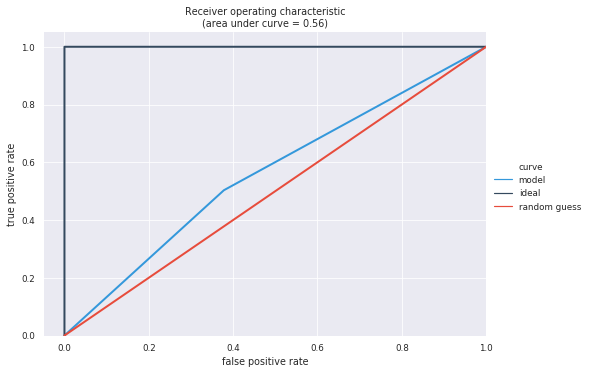

In [24]:
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, y_pred_xgb)
xgb_roc_auc = auc(xgb_fpr, xgb_tpr)

plot_roc(xgb_fpr, xgb_tpr, xgb_roc_auc)